In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# 시계열 데이터 준비

In [10]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [11]:
ts = df['Close']


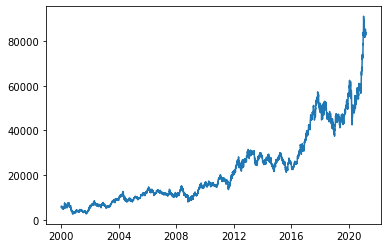

In [12]:
plt.plot(ts)

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [3]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# 결측치 보간 으로 제거

Series([], Name: Close, dtype: float64)


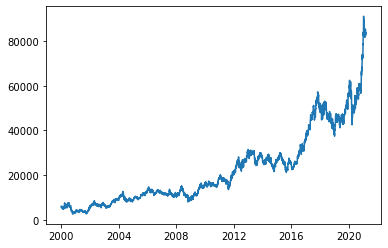

In [15]:
ts = ts.interpolate(method= 'time')
print(ts[ts.isna()])
plt.plot(ts)

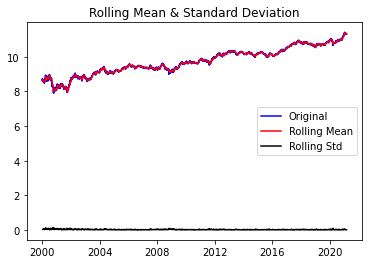

Results of Dickey-Fuller Test:
Test Statistic                   -0.317609
p-value                           0.922973
#Lags Used                        4.000000
Number of Observations Used    5316.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567059
dtype: float64


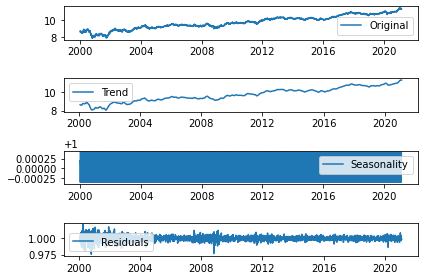

In [22]:
ts_log = np.log(ts)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [23]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760791e+01
p-value                        3.892499e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.257000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


### p-value가 이미 충분히 낮아 귀무가설(불안정하다)를 기각할 수 있고 '안정적이다'를 할 수 있는 대립가설을 채택할 수있다.

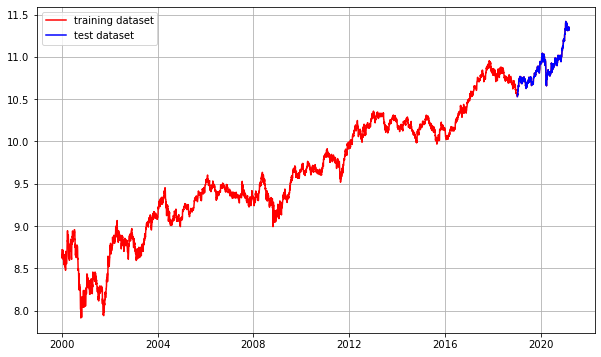

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

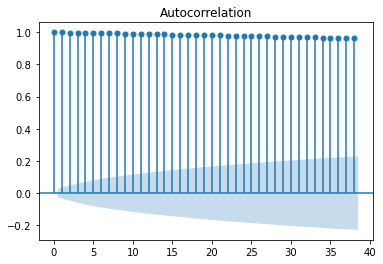

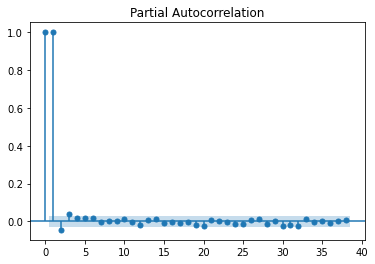

In [27]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.115957
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5316.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567059
dtype: float64


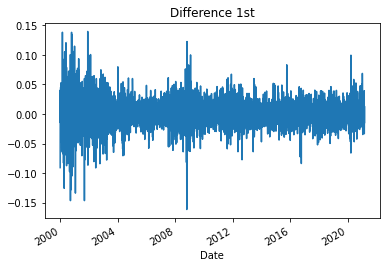

In [28]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                  -21.846926
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5285.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


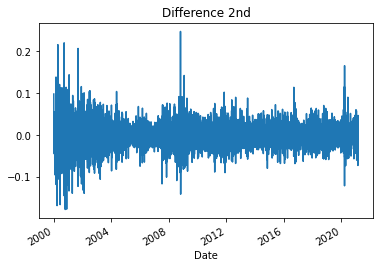

In [29]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [30]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11282.237
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22558.473
Time:                        11:16:31   BIC                         -22539.052
Sample:                             1   HQIC                        -22551.651
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.093      0.275      -0.000       0.001
ar.L1.D.Close     0.0436      0.014      3.017      0.003       0.015       0.072
                                    Root

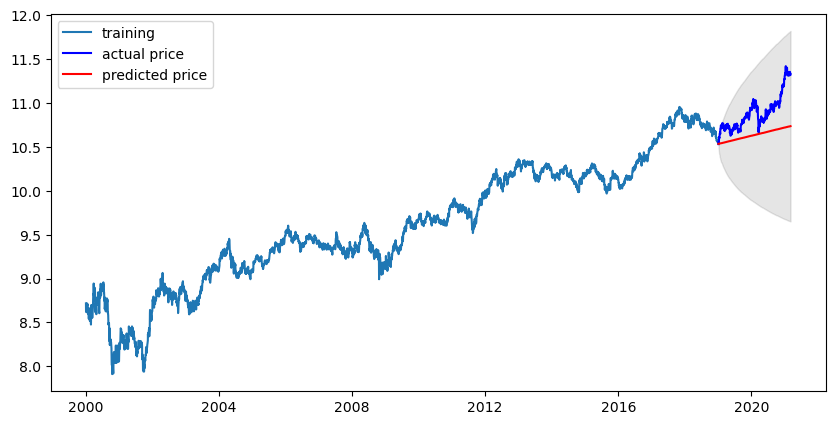

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  257690629.96534395
MAE:  12872.509757663163
RMSE:  16052.745247008188
MAPE: 21.50%


In [34]:
def train(df,d=1,tes=0.9,vis = True):
    ts = df['Close']
    # 결측치 제거
    ts = ts.interpolate(method= 'time')
    print(ts[ts.isna()])
    plt.plot(ts)

    ts_log = np.log(ts)
    if vis == True:
        # 정성적 그래프 분석
        plot_rolling_statistics(ts_log, window=12)

        #정량적 Augmented Dicky-Fuller Test

        augmented_dickey_fuller_test(ts_log)

    #시계열 분해 (Time Series Decomposition)
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    if vis == True:
        plt.subplot(411)
        plt.plot(ts_log, label='Original')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals')
        plt.legend(loc='best')
        plt.tight_layout()
        print('residual 분석')
        residual.dropna(inplace=True)
        augmented_dickey_fuller_test(residual)
    # 트레인 데이터 분리
    train_data, test_data = ts_log[:int(len(ts_log)*tes)], ts_log[int(len(ts_log)*tes):]
    if vis == True:
        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
        plt.plot(test_data, c='b', label='test dataset')
        plt.legend()

        plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
        plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
        plt.show()
        # 1차 차분 구하기
        diff_1 = ts_log.diff(periods=1).iloc[1:]
        diff_1.plot(title='Difference 1st')

        augmented_dickey_fuller_test(diff_1)

        # 혹시 필요한 경우 2차 차분 구하기
        diff_2 = diff_1.diff(periods=1).iloc[1:]
        diff_2.plot(title='Difference 2nd')

        augmented_dickey_fuller_test(diff_2)

    # Build Model
    model = ARIMA(train_data, order=(1, d, 0))  
    fitted_m = model.fit(disp=-1)
    if vis == True:  
        print(fitted_m.summary())
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))


In [5]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/KEP.csv' 
df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/LPL.csv' 
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

Series([], Name: Close, dtype: float64)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


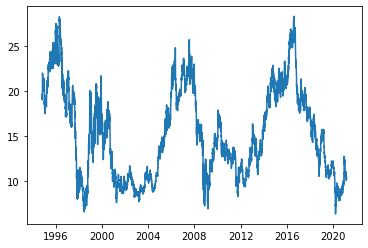

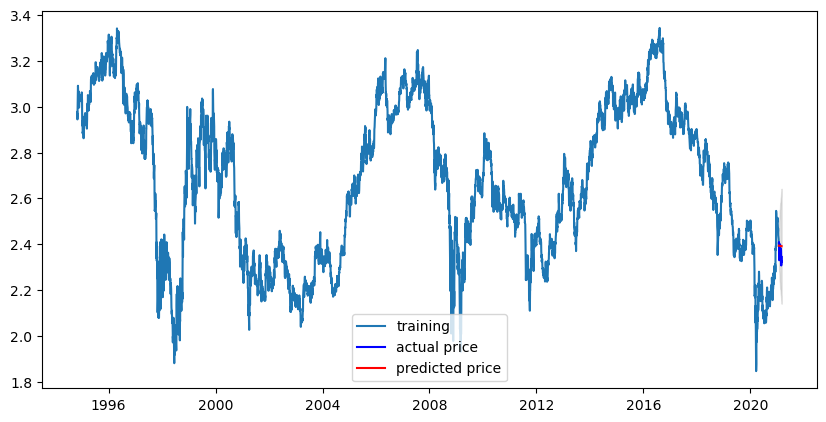

MSE:  0.16610333849966682
MAE:  0.33060640019719306
RMSE:  0.4075577732048143
MAPE: 3.17%


In [24]:
train(df1,tes=0.996,vis= False)

Series([], Name: Close, dtype: float64)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


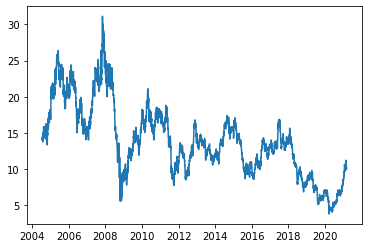

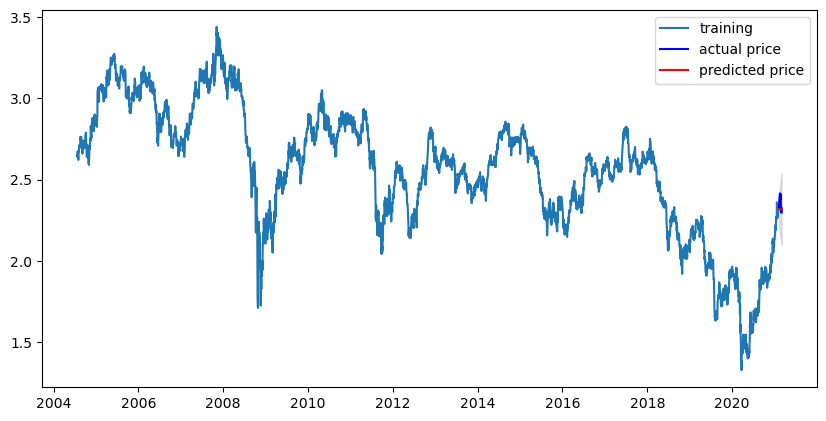

MSE:  0.36840136030509824
MAE:  0.4948684607948618
RMSE:  0.6069607568081302
MAPE: 4.55%


In [44]:
train(df2,d=1,tes=0.996,vis= False)

Series([], Name: Close, dtype: float64)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


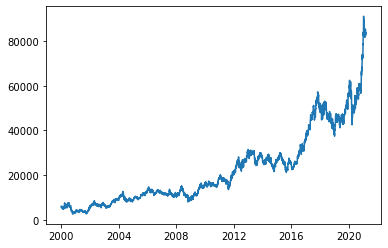

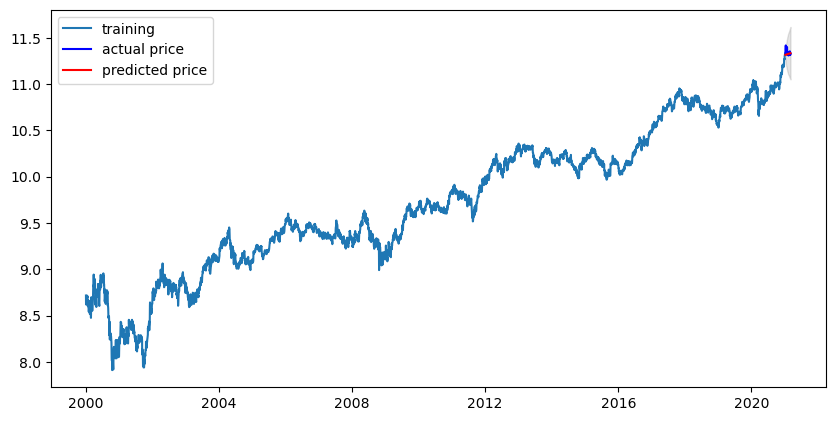

MSE:  13735219.244116135
MAE:  2648.6818134390146
RMSE:  3706.1056709322434
MAPE: 3.03%


In [45]:
train(df,d= 1,tes=0.993,vis = False)

# 고찰
차분하여 데이터 시계열의 안정성을 확인 하였고 보기 편하게 하기 위해 마지막 결과만을 보여주었다.
Max데이터를 가져오다보니 20년이상된 주식들은 테스트 비율을 매우 작게 하지않는이상 2년이상을 예상했어야 되엇다. 테스트비율을 약 2달정도를 예상하면 어느정도 괜찮게 예상을 하였다. 또한 코로나로 급변하는 상황에도 잘 작동한다는 것 자체가 신기했다. 